In [1]:
import os
from glob import glob
import shutil


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.model_selection import train_test_split

### All in together

In [2]:
# Generating csv file to gather data of images 

def generate_csv(root, img_ext = ['jpg', 'png', 'jpeg']):

    # create a dataframe to store the data we get from the file
    df = pd.DataFrame(columns = ['path', 'labels'])

    # os.listdir gives the folder name of the files
    for index, label in enumerate(os.listdir(root)):

            links = glob(f"{root}/{label}/*{img_ext}")           # glob used to get all information
            #print(len(links))

            # np.ones gives 1 to total number of links and multiply with index which starts from 0
            # np.ones(4)*3 = array([3, 3, 3, 3])
            # so by this we get both path for images and the labels in numbers till(0 - 120)
            temp_df = pd.DataFrame({'path': links, 'labels': np.ones(len(links))*index})

            df = pd.concat([df, temp_df], axis = 0)      # merge all in one
        
    return df

In [3]:
data = generate_csv('C:\\Users\\ritth\\code\\Data\\archive\\asl_alphabet_train\\asl_alphabet_train')
data

,path,labels
0,C:\Users\ritth\code\Data\archive\asl_alphabet_...,0.0
1,C:\Users\ritth\code\Data\archive\asl_alphabet_...,0.0
2,C:\Users\ritth\code\Data\archive\asl_alphabet_...,0.0
3,C:\Users\ritth\code\Data\archive\asl_alphabet_...,0.0
4,C:\Users\ritth\code\Data\archive\asl_alphabet_...,0.0
...,...,...
223,C:\Users\ritth\code\Data\archive\asl_alphabet_...,2.0
224,C:\Users\ritth\code\Data\archive\asl_alphabet_...,2.0
225,C:\Users\ritth\code\Data\archive\asl_alphabet_...,2.0
226,C:\Users\ritth\code\Data\archive\asl_alphabet_...,2.0


### Split the dataset

In [4]:
train_ds, test_ds = train_test_split(data, test_size = 0.2, random_state = 0, stratify = data["labels"])
train_ds, test_ds = train_ds.reset_index(drop=True), test_ds.reset_index(drop=True)
train_ds.shape, test_ds.shape

((642, 2), (161, 2))

In [5]:
test_ds.head()

,path,labels
0,C:\Users\ritth\code\Data\archive\asl_alphabet_...,0.0
1,C:\Users\ritth\code\Data\archive\asl_alphabet_...,0.0
2,C:\Users\ritth\code\Data\archive\asl_alphabet_...,1.0
3,C:\Users\ritth\code\Data\archive\asl_alphabet_...,0.0
4,C:\Users\ritth\code\Data\archive\asl_alphabet_...,1.0


In [6]:
data["path"].values

array(['C:\\Users\\ritth\\code\\Data\\archive\\asl_alphabet_train\\asl_alphabet_train/A\\A1.jpg',
       'C:\\Users\\ritth\\code\\Data\\archive\\asl_alphabet_train\\asl_alphabet_train/A\\A10.jpg',
       'C:\\Users\\ritth\\code\\Data\\archive\\asl_alphabet_train\\asl_alphabet_train/A\\A1000.jpg',
       'C:\\Users\\ritth\\code\\Data\\archive\\asl_alphabet_train\\asl_alphabet_train/A\\A1001.jpg',
       'C:\\Users\\ritth\\code\\Data\\archive\\asl_alphabet_train\\asl_alphabet_train/A\\A1002.jpg',
       'C:\\Users\\ritth\\code\\Data\\archive\\asl_alphabet_train\\asl_alphabet_train/A\\A1003.jpg',
       'C:\\Users\\ritth\\code\\Data\\archive\\asl_alphabet_train\\asl_alphabet_train/A\\A1004.jpg',
       'C:\\Users\\ritth\\code\\Data\\archive\\asl_alphabet_train\\asl_alphabet_train/A\\A1005.jpg',
       'C:\\Users\\ritth\\code\\Data\\archive\\asl_alphabet_train\\asl_alphabet_train/A\\A1006.jpg',
       'C:\\Users\\ritth\\code\\Data\\archive\\asl_alphabet_train\\asl_alphabet_train/A\\A1007.j

### Create a new folder

In [7]:
dest_folder_train = "C:\\Users\\ritth\\code\\Data\\archive\\train_data"
dest_folder_test = "C:\\Users\\ritth\\code\\Data\\archive\\test_data"

In [8]:
def copy_files(dest_folder, data):

    for pth in data.values[:, 0]:            # take the path to convert into images

        # 'C:\\Users\\ritth\\code\\Data\\datasciencebowl\\train\\train/siphonophore_physonect\\14249.jpg'
        # pth.split('/')[-1] = 'siphonophore_physonect\\14249.jpg'
        # ['siphonophore_physonect', '14249.jpg']
        folder_img = pth.split("/")[-1].split("\\")     
        folder, img = folder_img[0], folder_img[1]


        # folder join with the path Eg:[C:\Users\ritth\code\Data\datasciencebowl\train_new\trichodesmium_tuft]
        label_folder = os.path.join(dest_folder, folder)

        if not os.path.isdir(label_folder):                # if the folder does not exist 
            os.mkdir(label_folder)                         # creating the folder 
        shutil.copy(pth , label_folder)                    # copy the content of source(images) to destination(folder)

In [9]:
copy_files(dest_folder_train, train_ds)
copy_files(dest_folder_test, test_ds)

### Preprocessing

In [10]:
train_transform = transforms.Compose([
                                    transforms.Resize((224, 224)),           # resize will resize all the images into same scale(same pixels) given images size are small and big, so we take approximitily 50
                                    transforms.RandomRotation(20),
                                    transforms.RandomResizedCrop(200),      # crop adjust the images to other images in features and we taken it as 28 smaller than resize
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize(
                                        mean=[0.485, 0.456, 0.406],        # normalize have mean and standard deviation for color pic (red, green, blue)
                                        std=[0.229, 0.224, 0.225]) 
                                    ])
    
    
test_transform = transforms.Compose([
                                    transforms.Resize((224, 224)),
                                    transforms.CenterCrop(200),
                                    transforms.ToTensor(),
                                    transforms.Normalize(
                                        mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])
                                   ])

### Load the data

In [11]:
# Load the training data
trainset = datasets.ImageFolder(dest_folder_train, transform = train_transform)
trainloader = DataLoader(trainset, batch_size = 64, shuffle = True)


# Load the test data
testset = datasets.ImageFolder(dest_folder_test,transform = test_transform)
testloader = DataLoader(testset, batch_size = 64, shuffle = False)

In [12]:
images, labels = iter(trainloader).next()
print(f'image size: {images[0].shape}')
trainset.classes

image size: torch.Size([3, 200, 200])


['A', 'B', 'C']

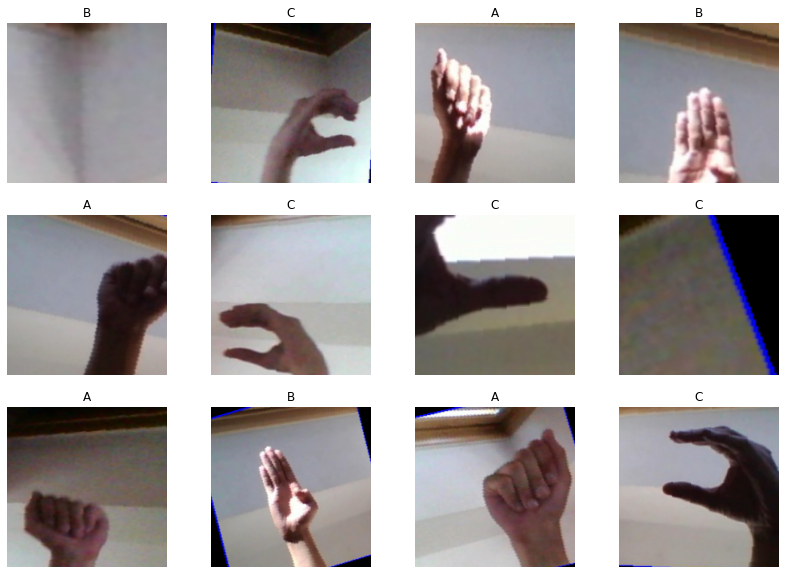

In [13]:
inv_normalize =  transforms.Normalize(
    mean=-1*np.divide([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
    std=1/np.array([0.229, 0.224, 0.225])
)

def class_plot(data , classes ,inv_normalize = None,n_figures = 12):
    n_row = int(n_figures/4)
    fig,axes = plt.subplots(figsize=(14, 10), nrows = n_row, ncols=4)
    for ax in axes.flatten():
        idx = np.random.randint(len(data))
        image,label = data[idx]
        label = int(label)
        l = classes[label]
        if(inv_normalize!=None):
            image = inv_normalize(image)
        image = image.numpy().transpose(1,2,0)
        im = ax.imshow(image)
        ax.set_title(l)
        ax.axis('off')
    plt.show()
class_plot(trainset,trainset.classes,inv_normalize)

### Model

In [16]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 16, 5)
        self.fc1 = nn.Linear(16*47*47, 220)
        self.fc2 = nn.Linear(220, 184)
        self.fc3 = nn.Linear(184, 93)
        self.fc4 = nn.Linear(93, 3)

        # Dropout module with a 0.2 drop probability 
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.shape)
        x = x.view(x.shape[0], -1)
        layer1 = self.dropout(F.relu(self.fc1(x)))
        layer2 = self.dropout(F.relu(self.fc2(layer1)))
        layer3 = self.dropout(F.relu(self.fc3(layer2)))
        out = F.log_softmax(self.fc4(layer3), dim=1)
    
        return out

model = Net()
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.003)

### Training and Validation

In [17]:
num_epochs = 10
train_losses, test_losses = [], []


for epoch in range(num_epochs):
    train_running_loss = 0 

    for images, labels in trainloader:
        output = model.forward(images)
        loss = criterion(output, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_running_loss += loss.item()
    else:
        test_running_loss = 0
        acc = 0

        # Turn off gradients for validation to save memory and speed up computations
        with torch.no_grad():
            model.eval()

            for images, labels in testloader:
                testoutput = model(images)
                testloss = criterion(testoutput, labels)
                test_running_loss += testloss.item()

                ps = torch.exp(testoutput)
                top_p, top_class = ps.topk(1, dim=1)                        # top_p = probability, top_class = index
                equals = top_class == labels.view(*top_class.shape)
                acc += equals.sum().item()
                
        model.train()
        
        # Get mean loss to enable comparison between train and test sets
        train_loss = train_running_loss/ len(trainloader.dataset)
        test_loss = test_running_loss / len(testloader.dataset)


        # At completion of epoch
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print("Epoch: {}/{}.. ".format(epoch+1, num_epochs),
              "Training Loss {:.3f}.. ".format(train_loss),
              "Test Loss {:.3f}.. ".format(test_loss),
              "Test Accuracy {:.3f}".format(acc / len(testloader.dataset)))
            
    

Epoch: 1/10..  Training Loss 0.021..  Test Loss 0.021..  Test Accuracy 0.404
Epoch: 2/10..  Training Loss 0.019..  Test Loss 0.021..  Test Accuracy 0.404
Epoch: 3/10..  Training Loss 0.019..  Test Loss 0.021..  Test Accuracy 0.404
Epoch: 4/10..  Training Loss 0.019..  Test Loss 0.021..  Test Accuracy 0.404
Epoch: 5/10..  Training Loss 0.019..  Test Loss 0.021..  Test Accuracy 0.404
Epoch: 6/10..  Training Loss 0.018..  Test Loss 0.021..  Test Accuracy 0.404
Epoch: 7/10..  Training Loss 0.019..  Test Loss 0.021..  Test Accuracy 0.404
Epoch: 8/10..  Training Loss 0.019..  Test Loss 0.021..  Test Accuracy 0.404
Epoch: 9/10..  Training Loss 0.018..  Test Loss 0.021..  Test Accuracy 0.404
Epoch: 10/10..  Training Loss 0.019..  Test Loss 0.021..  Test Accuracy 0.404


In [18]:
torch.save(model.state_dict(), 'model1.pth')

In [19]:
state_dict = torch.load('model1.pth')
print(state_dict.keys())

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias'])


In [20]:
import numpy as np
from PIL import Image

In [21]:
def make_prediction(model, image, classes):

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.CenterCrop(200),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])

    ])

    image = transform(image).unsqueeze(0)

    model.eval()
    with torch.no_grad():
        pred = torch.argmax(model(image), dim=1).item()

    return classes[pred]


# Load model
model.load_state_dict(torch.load('model1.pth'))

# Load classes for predictions
classes = ['A', 'B', 'C']

# Load image
img = Image.open('asl_alphabet_test\\asl_alphabet_test\\C_test.jpg')


print(make_prediction(model, img, classes))

A
